In [1]:
from validphys.api import API
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib.colors import LogNorm
import sys
from collections import namedtuple

# Add the path to the library folder
sys.path.append('./lib')

from model import PDFmodel
from validphys.api import API

from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import pandas as pd

In [2]:
seed = 14132124

In [3]:
evol_basis = np.array([
  'gamma',
  'Sigma',
  'g',
  'V',
  'V3',
  'V8',
  'V15',
  'V24',
  'V35',
  'T3',
  'T8',
  'T15',
  'T24',
  'T35'
])

evol_basis_tex = np.array([
  r'$\gamma$',
  r'$\Sigma$',
  r'$g$',
  r'$V$',
  r'$V_3$',
  r'$V_8$',
  r'$V_{15}$',
  r'$V_{24}$',
  r'$V_{35}$',
  r'$T_3$',
  r'$T_8$',
  r'$T_{15}$',
  r'$T_{24}$',
  r'$T_{35}$'
])

In [4]:
def generate_dicts(common_dict):
  """Collect the necessary data from `validphys` given a validphys-like
  dictionary.

  Returns
  -------
  Returns a named tuple with the following fields:
  - fk_tables: dict
    Dictionary of FK tables.
  - central_data: dict
    Dictionary of central data.
  - xgrid: np.array
    The largest grids amongst all datasets.
  - total_ndata_wc: int
    Total number of data points.
  - lumi_mapping: np.array
    Luminosity mapping.
  """
  groups_data = API.groups_data_by_process(**common_dict)

  # Initialize named tuple
  result_tuple = namedtuple('result_tuple', ('fk_tables', 'central_data', 'xgrid', 'total_ndata_wc', 'lumi_mapping'))

  # Initialise the dictionaries
  fk_table_dict = {}
  central_data_dict = {}
  lumi_mapping = np.array([])
  flag = True

  XGRID = np.array([])


  total_ndata_wc = 0
  for group_proc in groups_data:
    for exp_set in group_proc.datasets:
      dataset_name = exp_set.name
      dataset_size = exp_set.load_commondata().ndata
      total_ndata_wc += dataset_size
      cuts = exp_set.cuts
      central_data_dict[dataset_name] = exp_set.load_commondata().with_cuts(cuts).central_values.to_numpy()

      # Collect FKSpecs
      fk_data = exp_set.fkspecs[0].load_with_cuts(cuts)

      # Read FKData and FK table in numpy version
      fk_table = fk_data.get_np_fktable()
      fk_table_dict[dataset_name] = fk_table

      # Collect lumi mapping
      if flag:
        lumi_mapping = np.array(fk_data.luminosity_mapping)
        flag = False
      if not np.allclose(lumi_mapping, np.array(fk_data.luminosity_mapping)):
        raise ValueError('Lumi mapping is not the same for all datasets.')

      # xgrid for this dataset
      xgrid = fk_data.xgrid
      if xgrid.size > XGRID.size:
        XGRID = xgrid

      # Check that `large_xgrid` is just a small-x extension of xgrid
      for i, x in enumerate(xgrid):
        offset = XGRID.size - xgrid.size
        try:
          assert(np.isclose(x, XGRID[offset+i]))
        except AssertionError:
          print(f"`large_xgrid` is not an extension for {dataset_name}.")

  res = result_tuple(fk_tables=fk_table_dict, central_data=central_data_dict, xgrid=XGRID, total_ndata_wc=total_ndata_wc, lumi_mapping=lumi_mapping)
  return res


def pad_fk_tables(fk_table_dict, grid_size):
  res_dict = {}
  for dataset_name, fk_table in fk_table_dict.items():
    res_dict[dataset_name] = np.pad(fk_table, ((0, 0), (0,0), (grid_size - fk_table.shape[2], 0)), 'constant')
  return res_dict


def build_fk_matrix(fk_dict):
   """
   Construct the FK table matrix.

   Description
   -----------
   Each experiment is provided with an FK table. By construction, and
   for the present work, FK tables are padded with zeros such that
   the number of points in the x-grid is the same (i.e. 50). Thus,
   each FK table has shape (Ndat, 50, 9). First, the last two dimensions
   (which are equal for all FK tables) are flattened, thus leaving 
   the shape (Ndat, 450). Then, all FK tables are stacked together,
   yielding a matrix (tot_Ndat, 450), where `tot_Ndata` is the sum
   off all experimental point. In this way, each row of this matrix
   represents an experimental point and contains the information to
   compute its relative theoretical prediction.

   Parameters
   ----------
   fk_dict: dict
    Dictionary of FK tables.
   """
   ndata = 0
   for fk in fk_dict.values():
      ndata += fk.shape[0]

   FK = np.vstack([fk.reshape((fk.shape[0], fk.shape[1] * fk.shape[2])) for fk in fk_dict.values()])

   # Check that this FK is what we expect
   try:
     test_matrix = np.random.rand(FK.shape[0], FK.shape[0]) # Random matrix
     mat_prod = FK.T @ test_matrix  # Matrix product
 
     # Tensor product
     result = np.zeros((fk.shape[1], fk.shape[2], FK.shape[0]))
     I = 0
     for fk in fk_dict.values():
       ndata = fk.shape[0]
       result += np.einsum('Iia, IJ -> iaJ',fk, test_matrix[I : I + ndata, :])
       I += ndata
     
     result_flatten = result.reshape((result.shape[0] * result.shape[1], result.shape[2]))
     assert(np.allclose(result_flatten, mat_prod))
     assert(np.allclose(result, mat_prod.reshape((result.shape[0], result.shape[1], result.shape[2]))))
   except AssertionError:
     print('The FK matrix does not match with the FK dict.')
   else:
      return FK
   

def plot_matrix(matrix, x_labels, x_ticklocks, size=(20,20), fontsize=10, pad=10, y_labels=None, y_ticklocks=None):
  # Show the FK tables
  fig, ax = plt.subplots(figsize=size)
  matrixplot = ax.matshow(
      matrix,
      cmap=cm.Spectral_r,
      norm=mcolors.SymLogNorm(
          linthresh=0.00001, linscale=1, vmin=matrix.min(), vmax=matrix.max()
      ),
  )
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.5)
  cbar = fig.colorbar(matrixplot, cax=cax)
  cbar.ax.tick_params(labelsize=fontsize)

  ax.set_xticks(x_ticklocks)
  _ = ax.set_xticklabels(x_labels, rotation=20, ha="left", fontsize=fontsize)

  if y_labels is not None and y_ticklocks is not None:
    ax.set_yticks(y_ticklocks)
    _ = ax.set_yticklabels(y_labels, rotation=20, ha="left", fontsize=fontsize)
    ax.tick_params(axis='y', pad=pad)

  fig.tight_layout()
  return fig, ax

In [5]:
# List of DIS dataset
dataset_inputs = [
  #{'dataset': 'NMC_NC_NOTFIXED_P_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_P_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_D_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'BCDMS_NC_NOTFIXED_P_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'BCDMS_NC_NOTFIXED_D_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_NU-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_NB-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_NU-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_NB-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_225GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_251GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_300GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_CHARM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_BOTTOM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
]

# Dictionary for validphys API
common_dict = dict(
    dataset_inputs=dataset_inputs,
    metadata_group="nnpdf31_process",
    use_cuts='internal',
    datacuts={'q2min': 3.49, 'w2min': 12.5},
    theoryid=708,
    t0pdfset='NNPDF40_nnlo_as_01180',
    use_t0=True
)

In [6]:
# Retrieve data from NNPDF
tuple_of_dicts = generate_dicts(common_dict)
fk_table_dict = tuple_of_dicts.fk_tables
central_data_dict = tuple_of_dicts.central_data
lumi_mapping = tuple_of_dicts.lumi_mapping
XGRID = tuple_of_dicts.xgrid

fk_table_dict_padded = pad_fk_tables(fk_table_dict, XGRID.size)
FK = build_fk_matrix(fk_table_dict_padded)

In [7]:
C = API.groups_covmat_no_table(**common_dict)
Cinv = pd.DataFrame(np.linalg.inv(C), index=C.index, columns=C.columns)

# Diagonalize covariance matrix
eigvals_Cinv, R_Y = np.linalg.eigh(Cinv)
if eigvals_Cinv[-1] > eigvals_Cinv[0]:
    eigvals_Cinv = eigvals_Cinv[::-1]
    R_Y = R_Y[:,::-1]
D_Y = np.diag(eigvals_Cinv)

LHAPDF 6.5.4 loading /opt/homebrew/Caskroom/miniconda/base/envs/nnpdf/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


In [8]:
# Construct dataframe for predictions
Y = pd.DataFrame(np.zeros(Cinv.shape[0]), index=Cinv.index)
for exp_name, data in central_data_dict.items():
  if data.size == Y.loc[(slice(None), [exp_name], slice(None)), :].size:
    # (group, experiment, index)
    Y.loc[(slice(None), [exp_name], slice(None)), :] = data
  else:
    raise ValueError

In [9]:
nnpdf_model = PDFmodel(input=XGRID,
                       outputs=9,
                       architecture=[28,20],
                       activations=['tanh', 'tanh'],
                       kernel_initializer='RandomNormal',
                       user_ki_args={'mean': 0.0, 'stddev': 1.0},
                       seed=seed,
                       dtype='float64')
NTK = nnpdf_model.compute_ntk()

# Flatten NTK
prod = 1
oldshape = NTK.shape
for k in oldshape[2:]:
    prod *= k
NTK_flat = np.array(NTK).reshape(prod,-1)

# Compute predictions at initialization
f0 = nnpdf_model.predict(squeeze=True)

# Computing matrices from notes
-------------------------------

In [10]:
def regularize_matrix_svd(M, hermitean: bool = False, tol: float = None):
   """
   Regularization of a matrix wither with svd or evd depending
   on whether the matrix is symmetric or not.

   Description
   -----------
   When dealing with numerical precision issues in matrices (e.g. symmetric 
   matrices with eigenvalues spanning a very large range) regularization turns
   out to be essential. If the matrix is symmetric, the regularization is applied
   to the eigenvalues; if the matrix is not symmetric, the regularization is
   applied to the singular values. The tolerance, which defines the smallest
   distinguishable difference, is eps * max(s) where eps is the machine epsilon
   (~2.2e-16 for float64) and max(s) is the highest eigenvalue or the highest
   singular value.

   Parameters
   ----------
   M: np.ndarray
    The matrix that needs to be regularized. The matrix must be squared.
   tol: float
    The tolerance that defines the smallest distinguishable value. Default is None,
    and the tolerance is defined as eps * max(s).

   Returns
   -------
   If the matrix is symmetric, it returns the regularized matrix and a tuple
   containing the regularized eigenvalues in first position and the respective
   eigenvectors in second position. If the matrix is not symmetric, it returns
   the regularized matrix, and a tuple (U, S_reg, Vh).
   """
   U, S, Vh = np.linalg.svd(M, full_matrices=False, hermitian=hermitean)
   if tol is None:
     tol = np.amax(S, initial=0.) * np.finfo(M.dtype).eps
   reg_S = np.where(S > tol, S, 0.0)
   M_reg = np.dot(U * reg_S, Vh)
      
   return M_reg, (reg_S, Vh, U, tol)

# $M = (FK)^T C_Y^{-1} (FK) = RDR^T$
Here I compute the matrix $M$ as defined above. Then I check that the SVD gives the same result as the eigen decomposition

In [11]:
# Compute M and make a copy
M = FK.T @ Cinv.to_numpy() @ FK

# Check that M is symmetric
assert(np.allclose(M, M.T))

The plot above shows that the two systems are exactly the same up to the numerical precision. Below this threshold, any value should be interpreted as numerical noise and hence must be set to zero. This form of regularization is performed in the following cell.

In [12]:
# Compute first SVD
_, S_M, _ = np.linalg.svd(M, full_matrices=True, hermitian=True)

# Define tolerance for comparison
rtol_M = np.amax(S_M, initial=0.) * np.finfo(M.dtype).eps * M.shape[0]

# Find the index of the first null value
arg_first_zero = np.argwhere(S_M < rtol_M)[0][0]

# Regularize the matrix
M_reg, (S_M_reg, Vh_M, U_M, tol) = regularize_matrix_svd(M, tol=rtol_M, hermitean=True)

In [13]:
# Project into the orthogonal spacei 
M_orth = np.diag(S_M_reg[:arg_first_zero])
print(f"Original dimension of the singular space : {S_M_reg.size}")
print(f"Dimension of the orthogonal subspace : {M_orth.shape[0]}")

Original dimension of the singular space : 450
Dimension of the orthogonal subspace : 310


Here we cann see how this cut affects the inverse problem

In [14]:
cut_size = 150
reduced_space_size = arg_first_zero - cut_size
M_orth = np.diag(S_M_reg[:reduced_space_size])
M_orth_inv = np.linalg.inv(M_orth)
FK_orth = FK @ U_M[:, :reduced_space_size]

# Test that the explicit projection is the diagonal matrix M_orth defined above
M_test = U_M[:, :reduced_space_size].T @ M @ U_M[:, :reduced_space_size]
assert(np.allclose(M_test, M_orth))

In [15]:
C_chol = np.linalg.cholesky(C.to_numpy())
rng = np.random.default_rng(seed=124234 + 1)
pseudodata = Y.to_numpy(dtype='float64').reshape(-1) + C_chol @ rng.normal(size=Y.size)

/var/folders/l5/l1kl3n_11gx3zm7b0wxctqym0000gn/T/ipykernel_47240/158144935.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


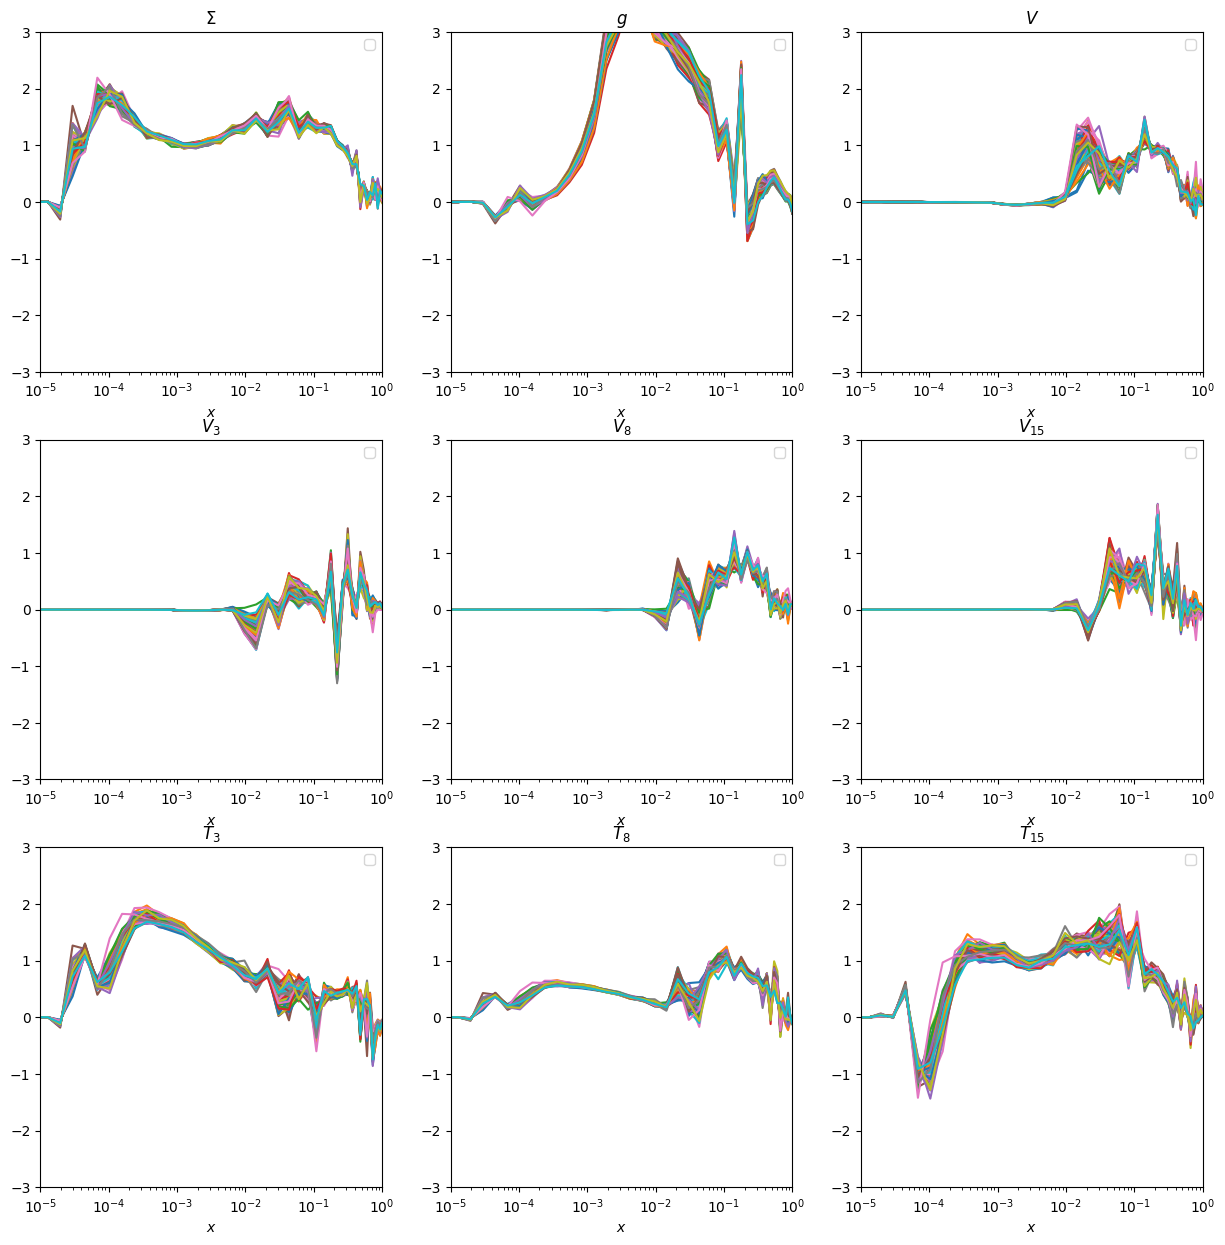

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

f_inf_list = []
eps_inf_list = []
L_inf_list = []
C_chol = np.linalg.cholesky(C)

for rep in range(100):
  rng = np.random.default_rng(seed=124234 + rep)
  pseudodata = Y.to_numpy(dtype='float64').reshape(-1) + C_chol @ rng.normal(size=Y.size)
  f_inf = M_orth_inv @ FK_orth.T @ Cinv.to_numpy(dtype='float64') @ pseudodata
  # eps_inf = Y.to_numpy(dtype='float64')[:,0] - FK_orth @ f_inf
  # L_inf = 0.5 * Y.to_numpy(dtype='float64')[:,0].T @ Cinv.to_numpy(dtype='float64') @ eps_inf / Y.size
  # f_inf_list.append(f_inf)
  # eps_inf_list.append(eps_inf)
  # L_inf_list.append(L_inf)


  f = U_M[:, :reduced_space_size] @ f_inf
  f = f.reshape((9, f.size // 9))


  for j, ax in enumerate(axs.flatten()):
    ax.plot(XGRID, f[j])

for j, ax in enumerate(axs.flatten()):
  flav_label = evol_basis_tex[lumi_mapping[j]]
  ax.set_title(flav_label)
  ax.set_xscale('log')
  ax.set_xlim([1.e-5, 1.])
  ax.set_ylim([-3., 3.])
  ax.set_xlabel(r'$x$')
  ax.legend()

# NTK part

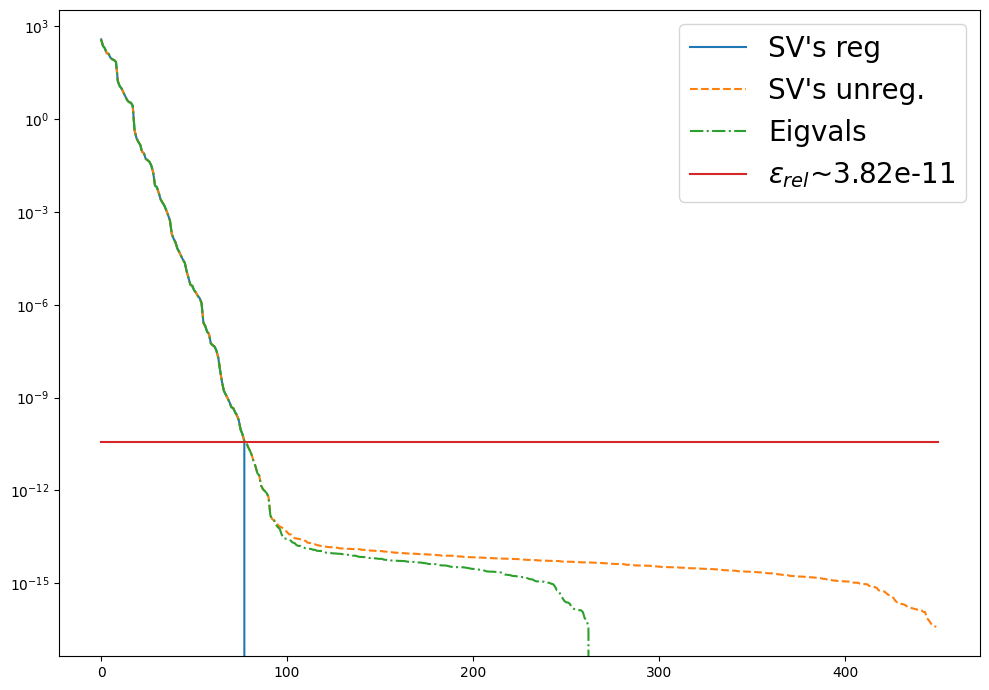

In [17]:
# Compute first SVD
_, S_ntk, _ = np.linalg.svd(NTK_flat, full_matrices=True, hermitian=True)

# Define tolerance for comparison
rtol_ntk = np.amax(S_ntk, initial=0.) * np.finfo(NTK_flat.dtype).eps * NTK_flat.shape[0]

# Find the index of the first null value
arg_first_zero = np.argwhere(S_ntk < rtol_ntk)[0][0]

# Compute the eigensystem 
eigvals_ntk, eigvecs_ntk = np.linalg.eigh(NTK_flat)
eigvals_ntk = eigvals_ntk[::-1]
eigvecs_ntk = eigvecs_ntk[:, ::-1]

# Regularize the matrix
ntk_reg, (S_ntk_reg, Vh_ntk, U_ntk, tol) = regularize_matrix_svd(NTK_flat, tol=rtol_ntk, hermitean=True)

# Plot singular values of the NTK
plt.figure(figsize=(10,7))
plt.plot(S_ntk_reg, label="SV's reg")
plt.plot(S_ntk, label="SV's unreg.", linestyle='--')
plt.plot(eigvals_ntk, label="Eigvals", linestyle='-.')
plt.plot(np.linspace(0,450,100), [rtol_ntk for _ in range(100)], label=r'$\varepsilon_{rel}$' +  f'~{rtol_ntk:.2e}')
#plt.xscale('log')
plt.yscale('log')
#plt.ylim([1.e-20,1.e8])
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('./plots/ntk_decomposition.png', bbox_inches='tight')

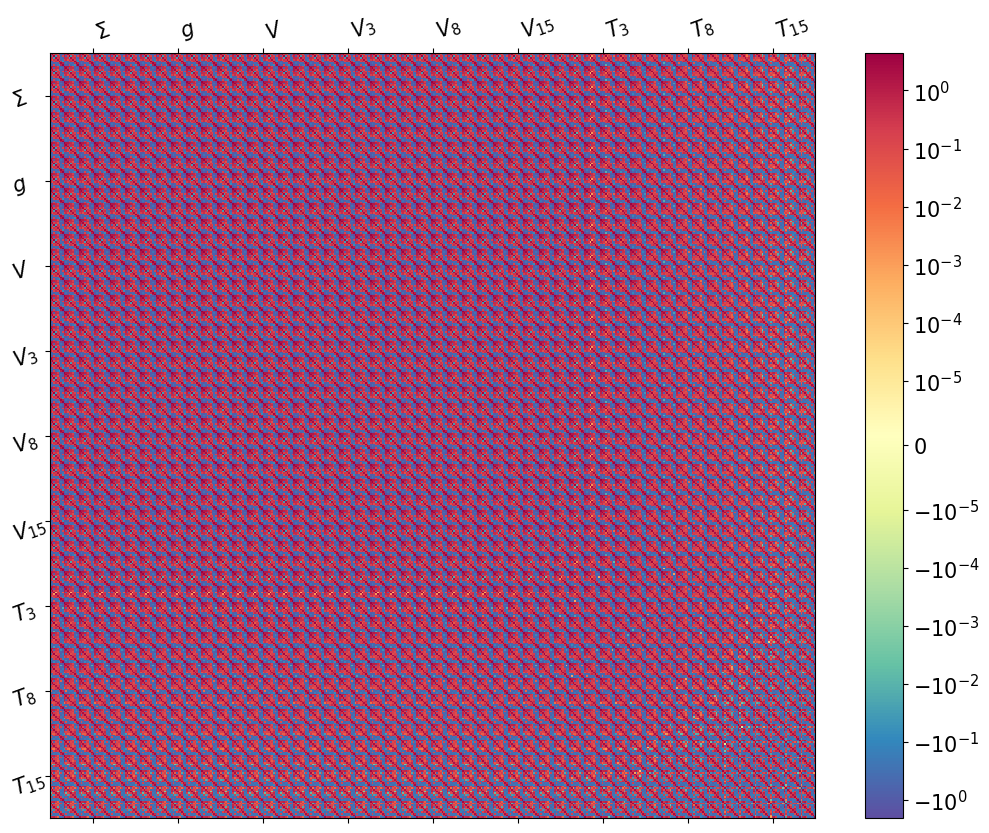

In [18]:
# Plot M
fig, _ = plot_matrix(NTK_flat, 
                     x_ticklocks=np.arange(XGRID.size//2, NTK_flat.shape[1] + XGRID.size//2, XGRID.size), 
                     x_labels=evol_basis_tex[lumi_mapping],
                     y_ticklocks=np.arange(XGRID.size//2, NTK_flat.shape[1] + XGRID.size//2, XGRID.size), 
                     y_labels=evol_basis_tex[lumi_mapping], 
                     size=(10,10), fontsize=15,
                     pad=25)
fig.savefig('./plots/ntk_matrix.png', bbox_inches='tight')

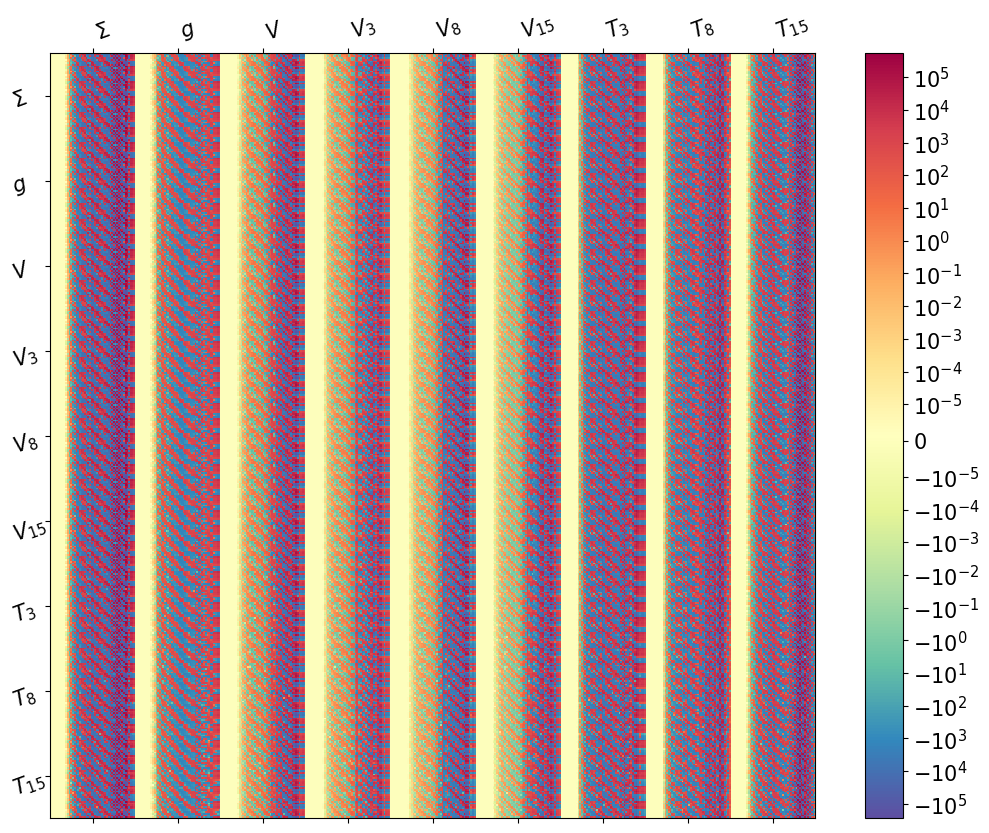

In [19]:
# Compute the full evolution kernel of the flow equation
kernel = NTK_flat @ M

fig, _ = plot_matrix(kernel, 
                     x_ticklocks=np.arange(XGRID.size//2, NTK_flat.shape[1] + XGRID.size//2, XGRID.size), 
                     x_labels=evol_basis_tex[lumi_mapping],
                     y_ticklocks=np.arange(XGRID.size//2, NTK_flat.shape[1] + XGRID.size//2, XGRID.size), 
                     y_labels=evol_basis_tex[lumi_mapping], 
                     size=(10,10), fontsize=15,
                     pad=25)
fig.savefig('./plots/evolution_kernel.png', bbox_inches='tight')

The flow equation is
$$
\frac{d}{dt}f_t = b - \Theta M f_t \,.
$$
We introduce the eigen-space of the NTK
$$
\Theta e^{(k)} = \lambda_k e^{(k)},
$$
onto which we project the flow equation
$$
\frac{d}{dt}f_{k,t}' = b_k' - \lambda_k (e^{(k)}, M f_t).
$$
Here, the primed quantities represent components in the NTK space, indexed by the subscript $k$, and $(e^{(k)}, M f_t)$ is the scalar product between an eigenvector of the NTK and the vector $Mf_t$. We can make two observations:

1. We know that many eigenvalues $\lambda_k$ vanish or are very small, so that the second term in the rhs of the equation above vanishes. Moreover, for the first term in the rhs we have
    $$
      b_k' = (e^{(k)}, b) = (e^{(k)}, \Theta (FK)^T C_Y^{-1} Y) = 0 \hspace{5mm} \forall e^{(k)} \in Ker(\Theta) .
    $$
   Thus for zero modes we have
   $$
    \frac{d}{dt} f_{k,t}' = 0 \hspace{5mm} \Rightarrow f_{k,t}' = f_{k,0}' .
   $$
2. The NTK specifies the first layer of modes that we can ever learn given the network, and thus it encodes the amount of information that the functional form can carry. However, we are still missing the physical bit, which is encoded in the matrix $M$. We can write
   $$
    M = LL^T = (RD^{1/2})(D^{1/2}R^T) \,,
   $$
   and then apply the completness relation of the NTK basis so that we have
   $$
    M_{k_1 k_2}' = (e^{(k_1)}, L e^{(k)})(e^{(k)}, L^T e^{(k_2)}).
   $$
   The flow equation can then be written as
   $$
   \begin{split}
    (L'^T)_{k'k} \frac{d}{dt}f_{k,t}' & = (L'^T)_{k'k} b_k' - (L'^T)_{k'k} \lambda_k (e^{(k)}, L e^{(k_1)}) (e^{(k_1)}, L^T e^{(k_2)}) (e^{(k_2)}, f_t)\\
    & = (L'^T)_{k'k} b_k' - (L'^T)_{k'k} \lambda_k L_{kk_1}' \left( (L'^T)_{k_1 k_2} f_{k_2,t}' \right) \\
    & = \tilde{b}_k' - (L'^T)_{k'k} \lambda_k L_{kk_1}' \tilde{f}_{k_1,t}' \,,
   \end{split}
   $$
   And finally we can write
   $$
   \begin{split}
    \frac{d}{dt} \tilde{f}_{k,t}' & = \tilde{b}_{k}' - (L'^T)_{kk'} \lambda_{k'} L_{k'k''}' \tilde{f}_{k'',t}' \\
    & = \tilde{b}_{k}' - \tilde{K}_{kk''} \tilde{f}_{k'',t}'
   \end{split}
   $$

There is a final caveat though. The matrix $M$ is ill-defined by construction, and it does not admit the Cholesky decomposition. However, we can use the SVD decomposition such that
$$
  M = U \Sigma V^T = (U \Sigma^{1/2}) (\Sigma^{1/2} V^T) .
$$
Also note the $U$ and $V$ are identical in the subspace of non-zero singular values, as explicitly checked in the notebook `check_zero_mode.ipynb`. Hence, we will write $L = U \Sigma^{1/2}$ and $R = \Sigma^{1/2} V^T$.

In [20]:
# Compute b
b = NTK_flat @ FK.T @ Cinv.to_numpy(dtype='float64') @ Y.to_numpy(dtype='float64')
b_prime = (U_ntk.T @ b).reshape(-1)

# Compute the Cholesky decomposition of M
L = U_M @ np.sqrt(np.diag(S_M_reg))

# And L.T should be the same as np.sqrt(np.diag(S_M_reg)) @ V_M.T
L_test = np.sqrt(np.diag(S_M_reg)) @ Vh_M
assert(np.allclose(L, L_test.T))

Now we compute $L_{kk'}' = (e^{(k)}, L e^{(k')})$ and $\tilde{K}$

In [29]:
L_prime = U_ntk.T @ L @ U_ntk
LT_prime_test = U_ntk.T @ L.T @ U_ntk
assert(np.allclose(L_prime.T, LT_prime_test))

# I try to remove the zero modes of the NTK from K first
rank_ntk = np.linalg.matrix_rank(ntk_reg, tol=rtol_ntk)
K_tilde = L_prime[:rank_ntk, :].T @ np.diag(S_ntk_reg[:rank_ntk]) @ L_prime[:rank_ntk, :]
K_tilde_test = L_prime.T @ np.diag(S_ntk_reg) @ L_prime

In [22]:
print(f"Condition number: {np.linalg.cond(K_tilde)}")
print(f"Rank of K_tilde: {np.linalg.matrix_rank(K_tilde)}")

# Even if numpy does not complain when inverting the matrix,
# the condition number is very large, which means that the
# inverse does not make sense
K_tilde_inv = np.linalg.inv(K_tilde)
test = K_tilde @ K_tilde_inv
print(test)

Condition number: 5.005555791848802e+19
Rank of K_tilde: 68
[[ 0.875       0.25       -1.1875     ...  2.015625    0.
   0.        ]
 [-2.125       1.859375   -0.78125    ...  2.75       -1.65625
   3.625     ]
 [ 0.5         0.30859375  0.0546875  ...  2.125       0.40625
  -0.25      ]
 ...
 [-0.09375    -0.04003906  0.2890625  ...  0.90625     0.2421875
   0.625     ]
 [-0.203125    0.03515625  0.09375    ...  0.21875     0.875
  -0.25      ]
 [-0.27441406  0.125       0.0625     ... -0.8125      0.3125
  -2.125     ]]


## Analysis of matrix $\tilde{K}$

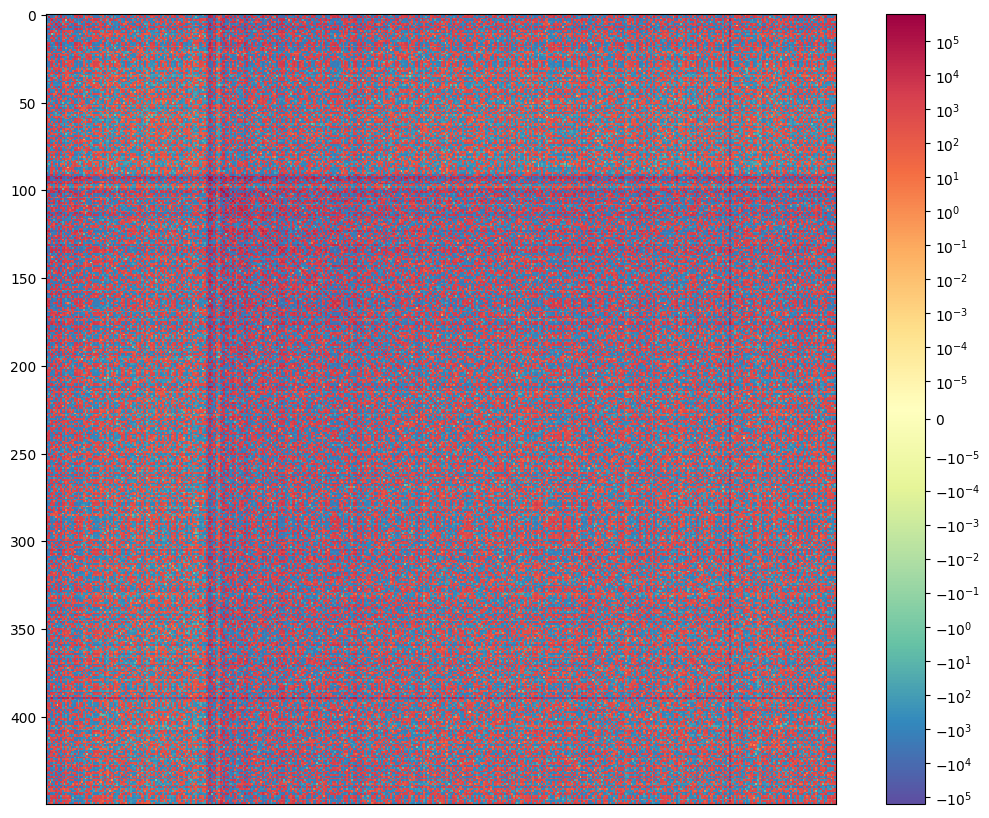

In [23]:
assert(np.allclose(K_tilde, K_tilde.T))

fig, _ = plot_matrix(K_tilde, x_ticklocks=[], x_labels=[], size=(10,10))

Max. singular value : 1.34e+06


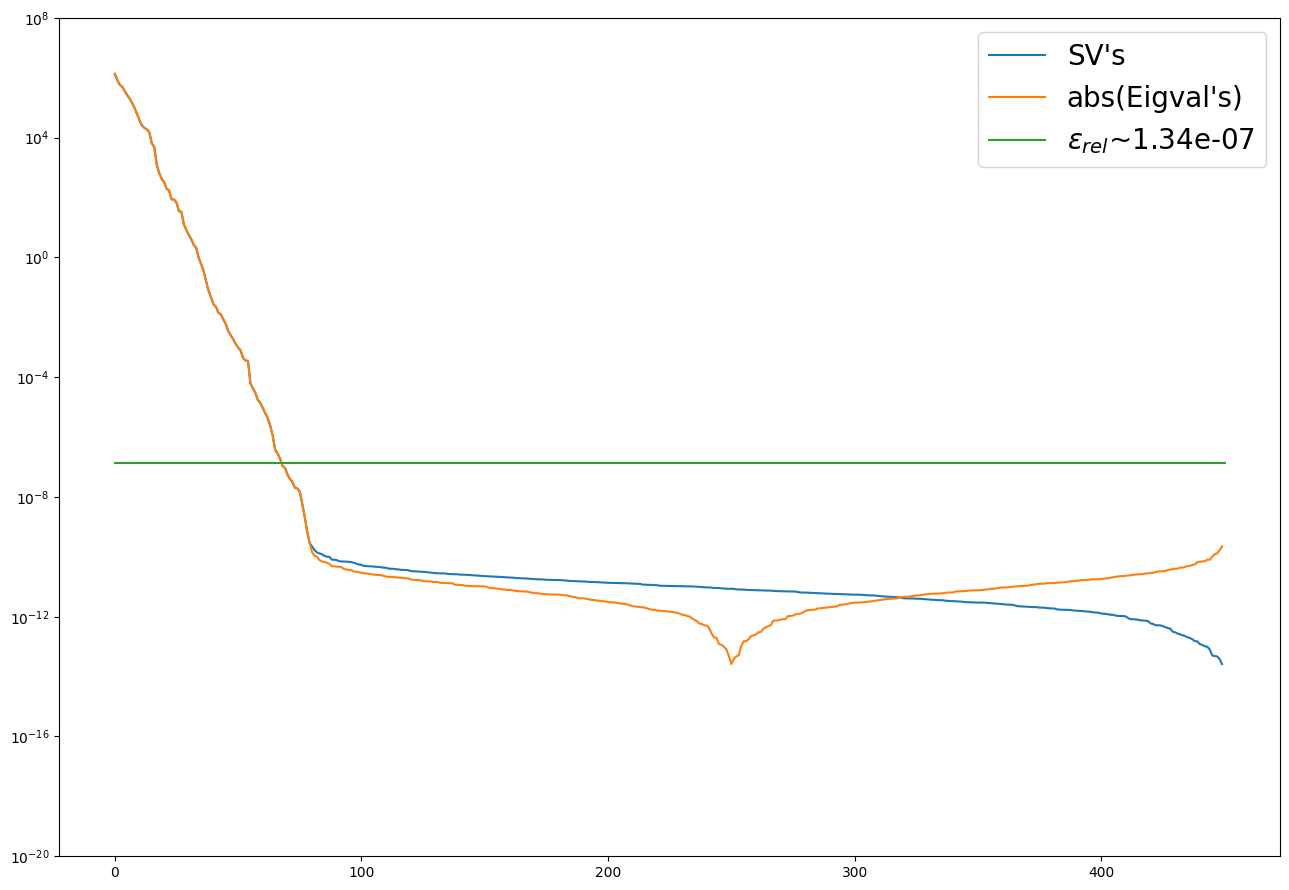

In [24]:
# Compute SVD
U_K, S_K, Vh_K = np.linalg.svd(K_tilde, full_matrices=True, hermitian=True)
V_K = Vh_K.T
print(f"Max. singular value : {S_K[0]:.2e}")

# Compute the eigensystem of the regularized matrix
eigvals_K, eigvecs_K = np.linalg.eigh(K_tilde)
eigvals_K = eigvals_K[::-1]
eigvecs_K = eigvecs_K[:, ::-1]

# Define tolerance for comparison
rtol_K = np.amax(S_K, initial=0.) * np.finfo(K_tilde.dtype).eps * K_tilde.shape[0]

# Plot singular- and eigen-values
plt.figure(figsize=(13,9))
plt.plot(S_K, label="SV's")
plt.plot(np.abs(eigvals_K), label="abs(Eigval's)")
plt.plot(np.linspace(0,450,100), [rtol_K for _ in range(100)], label=r'$\varepsilon_{rel}$' +  f'~{rtol_K:.2e}')
#plt.xscale('log')
plt.yscale('log')
plt.ylim([1.e-20,1.e8])
plt.legend(fontsize=20)
plt.tight_layout()

In [25]:
# Regularize the matrix
K_tilde_reg, (S_K_reg, Vh_K, U_K, tol) = regularize_matrix_svd(K_tilde, tol=rtol_K, hermitean=True)

# Regularize the eigenvalues
eigvals_K = [val if val > rtol_K else 0.0 for val in eigvals_K]

# Find the index of the first null value
arg_first_zero = np.argwhere(eigvals_K < rtol_K)[0][0]

# Print info
print(f"First zero argument : {arg_first_zero}")

First zero argument : 68


Write $K$ in the orthogonal space, and show that it is ill-defined.

In [ ]:
K_orth = np.diag(S_K_reg[:arg_first_zero])
print(f"Original dimension of the singular space : {S_K_reg.size}")
print(f"Dimensi on of the orthogonal subspace : {K_orth.shape[0]}")
print(f"Condition number of M in the diagonal basis: {K_orth.diagonal()[0]/K_orth.diagonal()[-1]}")
for j in range(arg_first_zero):
  K_orth = np.diag(S_K_reg[:arg_first_zero - j])
  print(f"Condition number of M in the diagonal basis with j = {j}: {K_orth.diagonal()[0]/K_orth.diagonal()[-1]}")

Original dimension of the singular space : 450
Dimension of the orthogonal subspace : 68
Condition number of M in the diagonal basis: 6999225356426.822
Condition number of M in the diagonal basis with j = 0: 6999225356426.822
Condition number of M in the diagonal basis with j = 1: 4780942814422.916
Condition number of M in the diagonal basis with j = 2: 3502880002055.834
Condition number of M in the diagonal basis with j = 3: 1195431555389.254
Condition number of M in the diagonal basis with j = 4: 548972570806.641
Condition number of M in the diagonal basis with j = 5: 313676778633.0949
Condition number of M in the diagonal basis with j = 6: 213883658255.6815
Condition number of M in the diagonal basis with j = 7: 144836333030.3893
Condition number of M in the diagonal basis with j = 8: 96398969022.73589
Condition number of M in the diagonal basis with j = 9: 77829502512.79204
Condition number of M in the diagonal basis with j = 10: 45453066505.33646
Condition number of M in the diago

The list above shows that we need to cut more values to get good condition number

In [27]:
cut_size = 60
reduced_space_size = arg_first_zero - cut_size
K_orth = np.diag(S_K_reg[:reduced_space_size]) 
K_orth_inv = np.linalg.inv(K_orth)

# Test that the explicit projection is the diagonal matrix M_orth defined above
K_test = U_K[:, :reduced_space_size].T @ K_tilde @ U_K[:, :reduced_space_size]
assert(np.allclose(K_test, K_orth))